# Notebook to show results

Import libraries needed

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.patches as mpatches

In [2]:
from modules.config import (RESULTS_DIR,
                            RESULTS_FILE, 
                            GRAPH_DIR,
                            )

SPACE = ' '

## define standard function modules

In [3]:
def read_data():
    """read data from csv file into pandas dataframe"""
    results_path = Path(RESULTS_DIR).joinpath(RESULTS_FILE)
    df = pd.read_csv(results_path)
    return df

In [4]:
def filter_results_general(df):
    """based on standard parameters"""    
    df = df[(df['formulation'] == 'original')]
    df = df[(df['hot_start'] == False)]
    df = df[(df['gray'] == False)]
    df = df[(df['iterations'] == 250)]
    return df

Filter out records for analysis

In [5]:
def filter_results_qml(df):
    """based on standard parameters"""    
    df = df[(df['quantum'] == True)]
    df = filter_results_general(df)
    df = df[(df['gradient_type'] == 'SPSA')]
    df = df[(df['alpha'] == 0.602)]
    df = df[(df['big_a'] == 25)]
    df = df[(df['c'] == 0.314)]
    df = df[(df['gamma'] == 0.101)]
    df = df[(df['eta'] == 0.1)]
    df = df[(df['s'] == 0.5)]
    return df

In [6]:
def filter_results_ml(df):
    """based on standard parameters"""    
    df = df[(df['quantum'] == False)]
    df = filter_results_general(df)
    df = df[(df['shots'] == 64)]
    df = df[(df['std_dev'] == 0.05)]
    df = df[(df['lr'] == 2e-5)]
    df = df[(df['weight_decay'] == 0.0006)]
    df = df[(df['momentum'] == 0.8)]
    return df

In [7]:
def find_quality(df):
    df['quality'] =  df['best_dist'] / df['best_dist_found'] 
    df['error'] = 1 - df['quality']
    return df

In [8]:
def select_key_fields_qml(df):
    df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode']]
    return df

In [9]:
def select_key_fields_ml(df):
    df = df[['locations', 'iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'layers']]
    return df

## Analysis of slicing

In [10]:
df = read_data()
df = filter_results_qml(df)
df = find_quality(df)
df = select_key_fields_qml(df)
df = df[(df['mode'] == 2)]
df = df[(df['locations'] > 8)]

Add quality and error

In [11]:
df.head()

,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
169,10,1.0,2,290.2,290.2,1.000000,0.000000,2
179,10,1.0,73,290.2,290.2,1.000000,0.000000,2
192,10,1.0,116,290.2,290.2,1.000000,0.000000,2
204,10,1.0,12,290.3,290.2,0.999656,0.000344,2
671,9,1.0,181,286.7,286.7,1.000000,0.000000,2


In [12]:
grouped_means = df.groupby(['locations', 'slice']).mean().reset_index()
#grouped_means = df.groupby(['locations', 'slice']).count().reset_index()
grouped_means.head()

,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,9,0.1,47.8,286.70,286.7,1.000000,0.000000,2.0
1,9,0.2,98.2,286.70,286.7,1.000000,0.000000,2.0
2,9,0.3,46.6,286.82,286.7,0.999582,0.000418,2.0
3,9,0.4,57.8,286.82,286.7,0.999582,0.000418,2.0
4,9,0.5,74.8,286.70,286.7,1.000000,0.000000,2.0


In [13]:
def plot_3d_graph_models(grouped_means, input):
    """plot a 3D bar graph of the given input data grouped by layers and locations"""   
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Map categorical data to numeric positions
    layers = sorted(grouped_means['layers'].unique())
    locations = sorted(grouped_means['locations'].unique(), reverse=True)

    layer_map = {sli: i for i, sli in enumerate(layers)}
    loc_map = {loc: i for i, loc in enumerate(locations)}
    
    print(f'layer_map: {layer_map}')
    print(f'loc_map: {loc_map}')
    # Assign colors for each location
    colors = plt.get_cmap('Set3', len(layers))  # or 'Set3', 'Paired', etc.
    layer_colors = {layer: colors(i) for i, layer in enumerate(layers)}

    # Bar sizes
    dx = 0.5
    dy = 0.1

    # Plot bars with different colors
    for i, row in grouped_means.iterrows():
        x = loc_map[row['locations']] - dx/2    # Center the bar on the x-axis
        y = layer_map[row['layers']] - dy/2  # Center the bar on the y-axis
        z = 0
        dz = row[input]

        color = layer_colors[row['layers']]
        ax.bar3d(x, y, z, dx, dy, dz, color=color, shade=True)

    # Label axes
    ax.set_xlabel('Locations')
    ax.set_ylabel('Layers')
    ax.set_zlabel(input)

    # Set tick labels
    ax.set_xticks(list(loc_map.values()))
    ax.set_xticklabels(list(loc_map.keys()))
    ax.set_yticks(list(layer_map.values()))
    ax.set_yticklabels(list(layer_map.keys()))

    legend_handles = [mpatches.Patch(color=layer_colors[layer], label=layer) for layer in layers]
    plt.legend(handles=legend_handles, title='Layers', loc='upper left', bbox_to_anchor=(1, 1))

    formatted_input = input.replace('_', SPACE).title()
    title = f'3D Bar Graph of {formatted_input} by Layers and Locations'
    plt.title(title)
    filename = f'{input}_3d_bar_graph_models.png'
    filepath = Path(GRAPH_DIR).joinpath(filename)
    plt.savefig(filepath)
    plt.show()

In [14]:
def plot_3d_graph_slice(grouped_means, input):
    """plot a 3D bar graph of the given input data grouped by locations and slice."""   
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Map categorical data to numeric positions
    locations = grouped_means['locations'].unique()
    slices = sorted(grouped_means['slice'].unique())

    loc_map = {loc: i for i, loc in enumerate(locations)}
    slice_map = {sli: i for i, sli in enumerate(slices)}

    # Assign colors for each location
    colors = plt.get_cmap('Set3', len(locations))  # or 'Set3', 'Paired', etc.
    location_colors = {loc: colors(i) for i, loc in enumerate(locations)}

    # Bar sizes
    dx = 0.5
    dy = 0.25

    # Plot bars with different colors
    for i, row in grouped_means.iterrows():
        x = slice_map[row['slice']] - dx/2    # Center the bar on the x-axis
        y = loc_map[row['locations']] - dy/2  # Center the bar on the y-axis
        z = 0
        dz = row[input]

        color = location_colors[row['locations']]
        ax.bar3d(x, y, z, dx, dy, dz, color=color, shade=True)

    # Label axes
    ax.set_xlabel('Slice')
    ax.set_ylabel('Locations')
    ax.set_zlabel(input)

    # Set tick labels
    ax.set_xticks(list(slice_map.values()))
    ax.set_xticklabels(list(slice_map.keys()))
    ax.set_yticks(list(loc_map.values()))
    ax.set_yticklabels(list(loc_map.keys()))

    legend_handles = [mpatches.Patch(color=location_colors[loc], label=loc) for loc in locations]
    plt.legend(handles=legend_handles, title='Locations', loc='upper left', bbox_to_anchor=(1, 1))

    formatted_input = input.replace('_', SPACE).title()
    title = f'3D Bar Graph of {formatted_input} by Location and Slice'
    plt.title(title)
    filename = f'{input}_3d_bar_graph_slices.png'
    filepath = Path(GRAPH_DIR).joinpath(filename)
    plt.savefig(filepath)
    plt.show()

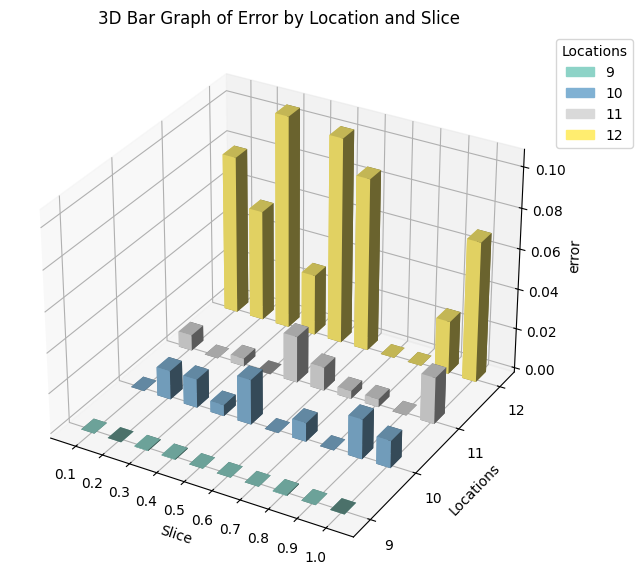

In [15]:
input = 'error'
plot_3d_graph_slice(grouped_means, input)

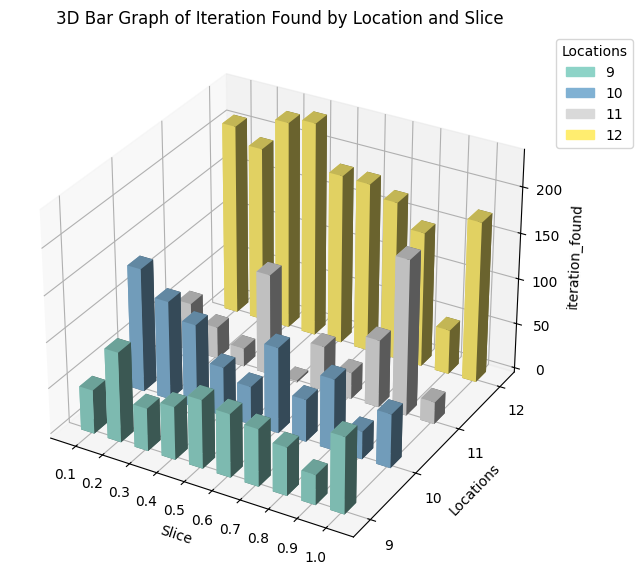

In [16]:
input = 'iteration_found'
plot_3d_graph_slice(grouped_means, input)

## Analysis of qml models

In [17]:
df = read_data()
df = filter_results_qml(df)
df = find_quality(df)
df = select_key_fields_qml(df)
df = df[(df['slice'] == 1.0)]

In [18]:
grouped_means2 = df.groupby(['mode', 'locations']).mean().reset_index()
grouped_means2.head()

,mode,locations,slice,iteration_found,best_dist_found,best_dist,quality,error
0,1,4,1.0,0.0,21.0,21.0,1.0,0.0
1,1,5,1.0,0.0,19.0,19.0,1.0,0.0
2,1,6,1.0,5.0,241.0,241.0,1.0,0.0
3,1,7,1.0,0.0,276.2,276.2,1.0,0.0
4,1,8,1.0,2.5,277.2,277.2,1.0,0.0


## Analysis of ml models

In [19]:
df = read_data()
df = filter_results_ml(df)
df = find_quality(df)
df = select_key_fields_ml(df)
df['layers'] = df['layers'].astype(int)

In [20]:
df.head()

,locations,iteration_found,best_dist_found,best_dist,quality,error,mode,layers
573,10,6,447.100006,290.2,0.649072,0.350928,8,2
591,10,9,328.700012,290.2,0.882872,0.117128,8,2
609,10,81,325.000000,290.2,0.892923,0.107077,9,2
610,10,26,356.700012,290.2,0.813569,0.186431,8,1
611,10,4,424.500000,290.2,0.683628,0.316372,8,2


In [21]:
grouped_means3 = df.groupby(['layers','locations', ]).mean().reset_index()
#grouped_means3 = df.groupby(['locations', 'layers']).count().reset_index()
grouped_means3.head()

,layers,locations,iteration_found,best_dist_found,best_dist,quality,error,mode
0,1,4,0.0,21.000000,21.0,1.000000,0.000000,8.0
1,1,5,0.0,19.000000,19.0,1.000000,0.000000,8.0
2,1,6,0.0,256.299988,241.0,0.940304,0.059696,8.0
3,1,7,2.0,308.000000,276.2,0.896753,0.103247,8.0
4,1,8,51.0,277.700012,277.2,0.998199,0.001801,8.0


layer_map: {np.int64(1): 0, np.int64(2): 1, np.int64(3): 2}
loc_map: {np.int64(48): 0, np.int64(42): 1, np.int64(26): 2, np.int64(17): 3, np.int64(15): 4, np.int64(12): 5, np.int64(11): 6, np.int64(10): 7, np.int64(9): 8, np.int64(8): 9, np.int64(7): 10, np.int64(6): 11, np.int64(5): 12, np.int64(4): 13}


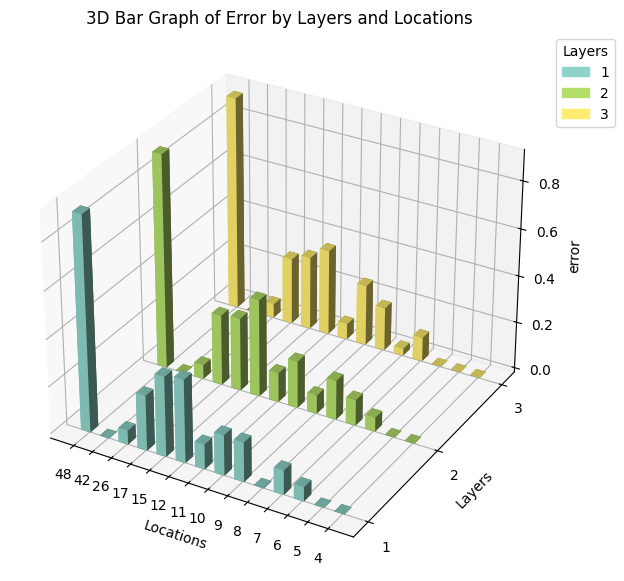

In [22]:
input = 'error'
plot_3d_graph_models(grouped_means3, input)